In [26]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')  

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [27]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [28]:
tf.test.is_gpu_available()

True

---

In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.9.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3675386014209189698
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4183621632
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16289748858677906448
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


---

---
# GPU performance test

## Modeling with MNIST

In [5]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 0 - 255    --> scaling pixel. karena max pixel itu 255
X_train = X_train / 255
X_test = X_test / 255

11490434/11490434 [==============================] - 3s 0us/step


In [6]:
import matplotlib.pyplot as plt

def show_image(image):
  plt.imshow(image, cmap='binary')

5


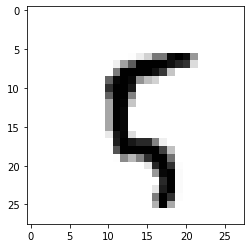

In [7]:
show_image(X_train[100])
print(y_train[100])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=46)

In [9]:
# siapkan label dengan One Hot Encoding
from tensorflow.keras.utils import to_categorical

y_train_ohe = to_categorical(y_train)
y_val_ohe = to_categorical(y_val)
y_test_ohe = to_categorical(y_test)

In [19]:
# membuat model dengan Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout

# deklarasi arsitektur
data_in = Input(shape=(28,28))
data_flat = Flatten()(data_in)     # mem-Flatten data yg tadinya 28x28 menjadi 784. ---- 784 dari 28 dikali 28
data_drop = Dropout(0.25)(data_flat)
hidden_1 = Dense(256, activation='elu')(data_flat)   # yg masuk ke hidden layer 1 adalah data_flat
hidden_drop_1 = Dropout(0.25)(hidden_1)
hidden_2 = Dense(32, activation='elu')(hidden_1)   # yg masuk ke hidden layer 2 adalah hidden_1
hidden_drop_2 = Dropout(0.25)(hidden_2)
out = Dense(10, activation='softmax')(hidden_2)    # yg masuk ke outer layer adalah hidden_2

model = Model(inputs=data_in, outputs=out)


# compile
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',               # adam adalah optimizer paling modern
              metrics =['accuracy'])

# train
history = model.fit(X_train, y_train_ohe, epochs=30, validation_data=(X_val, y_val_ohe))

Epoch 1/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.2660 - accuracy: 0.9213 - val_loss: 0.1324 - val_accuracy: 0.9607
Epoch 2/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.1259 - accuracy: 0.9626 - val_loss: 0.0966 - val_accuracy: 0.9700
Epoch 3/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0869 - accuracy: 0.9732 - val_loss: 0.1079 - val_accuracy: 0.9672
Epoch 4/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0641 - accuracy: 0.9790 - val_loss: 0.0762 - val_accuracy: 0.9770
Epoch 5/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0485 - accuracy: 0.9847 - val_loss: 0.0839 - val_accuracy: 0.9762
Epoch 6/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0380 - accuracy: 0.9875 - val_loss: 0.0861 - val_accuracy: 0.9775
Epoch 7/30
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0308 - accuracy: 0.9900 - val_loss: 0.0842 - val_ac

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 256)               200960    
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dense_5 (Dense)             (None, 10)                330       
                                                                 
Total params: 209,514
Trainable params: 209,514
Non-trainable params: 0
_________________________________________________________________


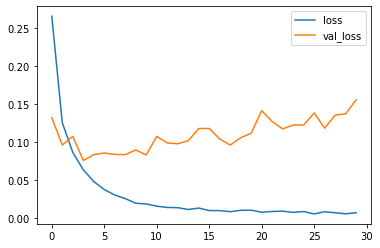

In [21]:
import pandas as pd
metrics = pd.DataFrame(history.history)
metrics[['loss','val_loss']].plot();

In [22]:
metrics = pd.DataFrame(history.history)   # di-convert ke dataframe
metrics.tail()

,loss,accuracy,val_loss,val_accuracy
25,0.005946,0.997981,0.138792,0.982000
26,0.008783,0.997315,0.118758,0.983333
27,0.007493,0.997778,0.135934,0.982667
28,0.006077,0.998130,0.137690,0.981667
29,0.007549,0.997852,0.156123,0.981000


In [25]:
from sklearn.metrics import classification_report
import numpy as np

y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
print(classification_report(y_test, y_pred))

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.98      0.97      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.98      0.97      0.97       892
           6       0.98      0.98      0.98       958
           7       0.97      0.98      0.98      1028
           8       0.98      0.97      0.97       974
           9       0.98      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

